In [149]:
#KÜTÜPHANELER
import os
import random
import shutil
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import resnet34, ResNet34_Weights  

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize


In [41]:
#ÇALIŞMA DİZİNİNİN AYARLANMASI VE HATA KONTROLÜ
try:
    os.chdir(r"C:\Users\Eda EROL\OneDrive\veriset")
    print("Yeni Dizin:", os.getcwd())
except FileNotFoundError:
    print("HATA: Belirtilen dizin bulunamadı.")


Yeni Dizin: C:\Users\Eda EROL\OneDrive\veriset


In [42]:
#GÖRÜNTÜ DOSYALARININ TEK BİR KLASÖRDE BİRLEŞTİRİLMESİ
src_dirs = ["HAM10000_images_part_1", "HAM10000_images_part_2"]
dst_dir = "all_images"
os.makedirs(dst_dir, exist_ok=True)

In [43]:
for folder in src_dirs:
    folder_path = os.path.join(os.getcwd(), folder)
    for file in os.listdir(folder_path):
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join(dst_dir, file)
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

In [44]:
print(f"Tüm görüntüler '{dst_dir}' klasöründe toplandı. Toplam: {len(os.listdir(dst_dir))} dosya")

Tüm görüntüler 'all_images' klasöründe toplandı. Toplam: 10015 dosya


In [45]:
#HAM10000 METADATA BİLGİLERİNİN YÜKLENMESİ
metadata_file = "HAM10000_metadata.csv"
metadata = []

In [46]:
with open(metadata_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        metadata.append(row)

In [47]:
print(f"Metadata yüklendi. Toplam satır: {len(metadata)}")

Metadata yüklendi. Toplam satır: 10015


In [48]:
#SINIF ETİKETLERİNİN SAYISAL İNDEKSLERLE EŞLEŞTİRİLMESİ
label_map = {
    "akiec": 0,
    "bcc": 1,
    "bkl": 2,
    "df": 3,
    "mel": 4,
    "nv": 5,
    "vasc": 6
}

In [49]:
#KULLANILABİLİR VERİ VE ETİKET LİSTELERİNİN OLUŞTURULMASI
data_list = []
labels = []

In [50]:
#GÖRÜNTÜ YOLLARININ VE ETİKETLERİN FİLTRELENİP LİSTEYE EKLENMESİ
for item in metadata:
    img_id = item["image_id"]
    label = label_map[item["dx"]]
    img_path = os.path.join(dst_dir, img_id + ".jpg")
    if os.path.exists(img_path):
        data_list.append(img_path)
        labels.append(label)

labels = np.array(labels)

In [51]:
#TOPLAM KULLANILABİLİR VERİ SAYISININ GÖSTERİLMESİ
print(f"Toplam kullanılabilir veri: {len(data_list)}")

Toplam kullanılabilir veri: 10015


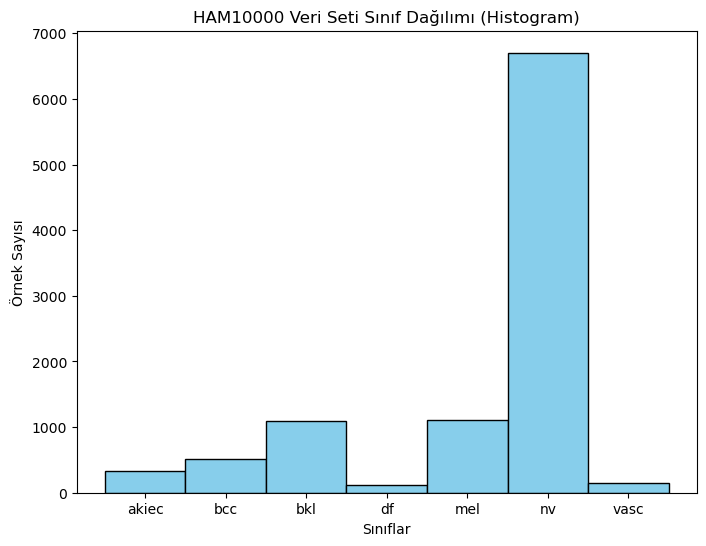

In [52]:
#VERİ SETİ SINIF DAĞILIMININ HİSTOGRAM İLE GÖRSELLEŞTİRİLMESİ
plt.figure(figsize=(8,6))
plt.hist(labels, bins=np.arange(8)-0.5, color='skyblue', edgecolor='black')  # 7 sınıf için 8 bin kenarı
plt.xticks(range(7), label_map.keys())  # Sınıf isimlerini x-axis'e ekle
plt.title("HAM10000 Veri Seti Sınıf Dağılımı (Histogram)")
plt.xlabel("Sınıflar")
plt.ylabel("Örnek Sayısı")
plt.show()

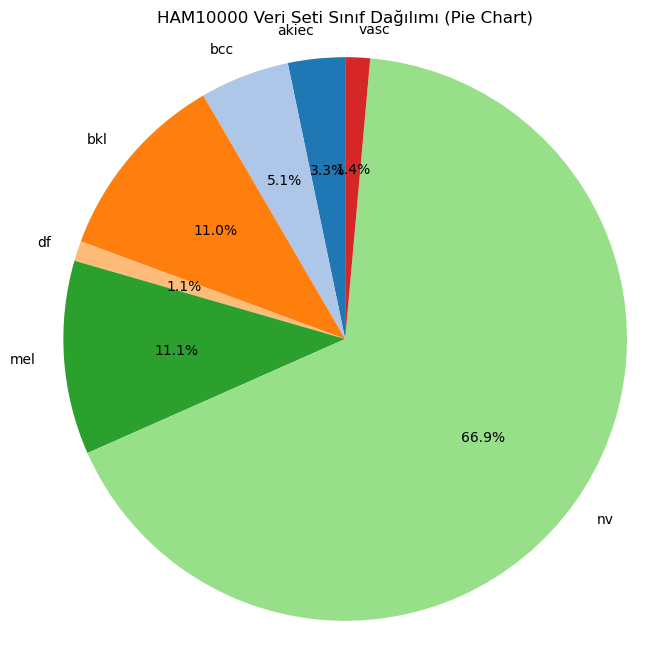

In [53]:
#VERİ SETİ SINIF DAĞILIMININ PIE CHART İLE GÖRSELLEŞTİRİLMESİ
label_counts = [np.sum(labels==i) for i in range(7)]
class_names = list(label_map.keys())

plt.figure(figsize=(8,8))
plt.pie(label_counts, labels=class_names, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)
plt.title("HAM10000 Veri Seti Sınıf Dağılımı (Pie Chart)")
plt.axis('equal')  # Dairesel görünüm için
plt.show()


In [54]:
#SINIF BAZLI STRATIFIED K-FOLD CROSS-VALIDATION OLUŞTURMA
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [55]:
#STRATIFIED K-FOLD İLE TRAIN+VALIDATION VE TEST SETLERİNİN OLUŞTURULMASI(İLK FOLD)
for train_val_idx, test_idx in skf.split(data_list, labels):
    X_train_val = np.array(data_list)[train_val_idx]
    y_train_val = labels[train_val_idx]
    X_test = np.array(data_list)[test_idx]
    y_test = labels[test_idx]
    break  #ilk fold alındı

In [56]:
#TRAIN VE VALIDATION SETLERİNİ STRATIFIED K-FOLD İLE BÖLME
skf2 = StratifiedKFold(n_splits=int(len(y_train_val)/int(len(y_train_val)*0.15)), shuffle=True, random_state=42)

In [57]:
#TRAIN+VALIDATION SETİ ÜZERİNDE STRATIFIED K-FOLD İLE TRAIN VE VALIDATION SETLERİNİN OLUŞTURULMASI (İLK FOLD)
for train_idx, val_idx in skf2.split(X_train_val, y_train_val):
    X_train = X_train_val[train_idx]
    y_train = y_train_val[train_idx]
    X_val = X_train_val[val_idx]
    y_val = y_train_val[val_idx]
    break

In [58]:
#TRAIN,VALIDATION VE TEST SETLERİNİN BOYUTLARININ YAZDIRILMASI
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 6676, Val: 1336, Test: 2003


In [59]:
#MODEL GİRİŞ GÖRÜNTÜ BOYUTU (224x224)
IMG_SIZE = 224 #Resnet34 için

In [60]:
#TRAIN TRANSFORMS
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [61]:
#VAL/TEST TRANSFORMS
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [62]:
#DATASET SINIFI:GÖRÜNTÜ YÜKLEME VE ÖN İŞLEME
class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [64]:
#TRAIN/VAL/TEST DATASET NESNELERİNİN OLUŞTURULMASI
train_dataset = SkinDataset(list(zip(X_train, y_train)), transform=train_transform)
val_dataset = SkinDataset(list(zip(X_val, y_val)), transform=val_test_transform)
test_dataset = SkinDataset(list(zip(X_test, y_test)), transform=val_test_transform)

In [65]:
#TRAIN/VAL/TEST DATALOADER OLUŞTURMA
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [66]:
print("DataLoader hazır!")

DataLoader hazır!


In [74]:
#MODELİN ÇALIŞACAĞI CİHAZIN (CPU/GPU) BELİRLENMESİ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
#ÖNCEDEN EĞİTİLMİŞ RESNET34 MODELİNİN YÜKLENMESİ
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

In [76]:
#SON FULLY CONNECTED KATMANIN 7 SINIFA UYGUN HALE GETİRİLMESİ
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

In [77]:
#MODELİN BELİRLENEN CİHAZA(CPU/GPU) TAŞINMASI
model = model.to(device)

In [78]:
#KAYIP FONKSİYONUNUN(LOSS FUNCTION) TANIMLANMASI
criterion = nn.CrossEntropyLoss()

In [82]:
#TÜM MODEL KATMANLARININ AĞIRLIKLARININ DONDURULMASI(SADECE FC LAYER EĞİTİLECEK)
for param in model.parameters():
    param.requires_grad = False

In [83]:
#SADECE FULLY CONNECTED(FC) KATMANININ EĞİTİLEBİLİR HALE GETİRİLMESİ
for param in model.fc.parameters():
    param.requires_grad = True

In [84]:
#FC KATMANI İÇİN OPTIMIZER’IN TANIMLANMASI VE ÖĞRENME ORANININ BELİRLENMESİ
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

In [85]:
#EĞİTİM PARAMETRELERİNİN VE EARLY STOPPING DEĞİŞKENLERİNİN TANIMLANMASI
num_epochs_fc = 10  
patience = 3
best_val_acc = 0
patience_counter = 0

In [86]:
#EĞİTİM VE DOĞRULAMA KAYIPLARI İLE DOĞRULUKLARININ TAKİBİ İÇİN LİSTELERİN OLUŞTURULMASI
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [87]:
print("Sadece FC layer eğitimi başlıyor")

Sadece FC layer eğitimi başlıyor


In [88]:
for epoch in range(num_epochs_fc):
    #TRAIN(EĞİTİM)
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total

    #VALIDATION(DOĞRULAMA)
    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs,1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    #HER EPOCH SONUNDA KAYIP VE DOĞRULUK DEĞERLERİNİN LİSTEYE EKLENMESİ
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[FC TRAIN] Epoch {epoch+1}/{num_epochs_fc} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    #EARLY STOPPING
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_fc_layer.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping çalıştı! [FC Layer]")
            break

[FC TRAIN] Epoch 1/10 | Train Loss: 0.9312 | Val Loss: 0.7847 | Train Acc: 0.6838 | Val Acc: 0.7208
[FC TRAIN] Epoch 2/10 | Train Loss: 0.7601 | Val Loss: 0.7544 | Train Acc: 0.7236 | Val Acc: 0.7365
[FC TRAIN] Epoch 3/10 | Train Loss: 0.7076 | Val Loss: 0.7200 | Train Acc: 0.7392 | Val Acc: 0.7403
[FC TRAIN] Epoch 4/10 | Train Loss: 0.6834 | Val Loss: 0.7210 | Train Acc: 0.7504 | Val Acc: 0.7425
[FC TRAIN] Epoch 5/10 | Train Loss: 0.6748 | Val Loss: 0.6937 | Train Acc: 0.7519 | Val Acc: 0.7425
[FC TRAIN] Epoch 6/10 | Train Loss: 0.6541 | Val Loss: 0.7869 | Train Acc: 0.7599 | Val Acc: 0.7260
[FC TRAIN] Epoch 7/10 | Train Loss: 0.6371 | Val Loss: 0.7291 | Train Acc: 0.7638 | Val Acc: 0.7358
Early stopping çalıştı! [FC Layer]


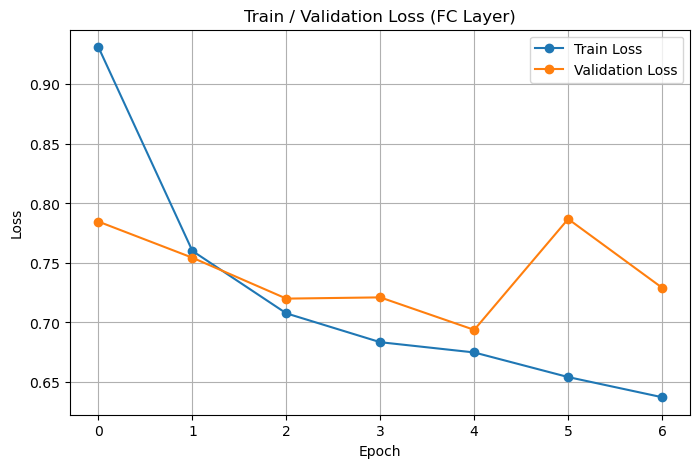

In [95]:
#TRAIN VE VALIDATION LOSS GRAFİĞİ
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train / Validation Loss (FC Layer)")
plt.legend()
plt.grid(True)
plt.show()


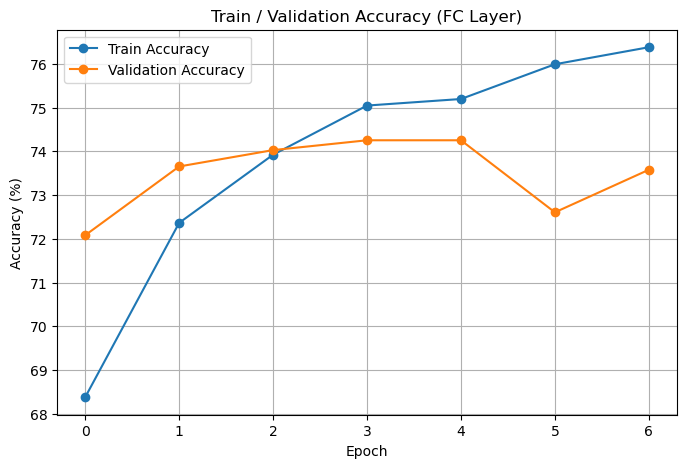

In [96]:
#TRAIN VE VALIDATION ACCURACY GRAFİĞİ
plt.figure(figsize=(8,5))
plt.plot([a*100 for a in train_accs], label="Train Accuracy", marker='o')
plt.plot([a*100 for a in val_accs], label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train / Validation Accuracy (FC Layer)")
plt.legend()
plt.grid(True)
plt.show()

In [97]:
#TEST ACCURACY
test_accuracy = correct / total

In [98]:
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7638


In [100]:
#FULL FINE-TUNING:TÜM KATMANLAR
#EN İYİ KAYDEDİLMİŞ MODELİN YÜKLENMESİ
model.load_state_dict(torch.load("best_fc_layer.pth"))

<All keys matched successfully>

In [99]:
#TÜM MODEL PARAMETRELERİNİN FINE-TUNING İÇİN AÇILMASI
for param in model.parameters():
    param.requires_grad = True


In [101]:
#FİNE-TUNING İÇİN OPTİMİZER VE KÜÇÜK LEARNING RATE AYARI
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # küçük LR fine-tuning için

In [102]:
#FİNE-TUNING EĞİTİM PARAMETRELERİ VE EARLY STOPPING AYARLARI
num_epochs_ft = 10
patience = 3
best_val_acc = 0
patience_counter = 0

In [103]:
#FİNE-TUNING İÇİN KAYIP VE DOĞRULUK DEĞERLERİNİ TUTAN LİSTELER
train_losses_ft = []
val_losses_ft = []
train_accs_ft = []
val_accs_ft = []

In [104]:
print("Full Fine-Tuning başlıyor")

Full Fine-Tuning başlıyor


In [105]:
for epoch in range(num_epochs_ft):
    #TRAIN(EĞİTİM)
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total

    #VALIDATION(DOĞRULAMA)
    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs,1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    #FİNE-TUNING EĞİTİMİ METRİKLERİNİ LİSTEYE EKLEME
    train_losses_ft.append(train_loss)
    val_losses_ft.append(val_loss)
    train_accs_ft.append(train_acc)
    val_accs_ft.append(val_acc)

    print(f"[FINE-TUNING] Epoch {epoch+1}/{num_epochs_ft} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    #EARLY STOPPING
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_finetuned_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping çalıştı! [Full Fine-Tuning]")
            break


[FINE-TUNING] Epoch 1/10 | Train Loss: 0.6051 | Val Loss: 0.5093 | Train Acc: 0.7794 | Val Acc: 0.8204
[FINE-TUNING] Epoch 2/10 | Train Loss: 0.4251 | Val Loss: 0.5435 | Train Acc: 0.8411 | Val Acc: 0.8174
[FINE-TUNING] Epoch 3/10 | Train Loss: 0.3520 | Val Loss: 0.4448 | Train Acc: 0.8686 | Val Acc: 0.8323
[FINE-TUNING] Epoch 4/10 | Train Loss: 0.2755 | Val Loss: 0.4070 | Train Acc: 0.8992 | Val Acc: 0.8548
[FINE-TUNING] Epoch 5/10 | Train Loss: 0.2319 | Val Loss: 0.4358 | Train Acc: 0.9148 | Val Acc: 0.8368
[FINE-TUNING] Epoch 6/10 | Train Loss: 0.1874 | Val Loss: 0.5100 | Train Acc: 0.9286 | Val Acc: 0.8428
[FINE-TUNING] Epoch 7/10 | Train Loss: 0.1674 | Val Loss: 0.4756 | Train Acc: 0.9407 | Val Acc: 0.8600
[FINE-TUNING] Epoch 8/10 | Train Loss: 0.1345 | Val Loss: 0.4844 | Train Acc: 0.9516 | Val Acc: 0.8488
[FINE-TUNING] Epoch 9/10 | Train Loss: 0.1136 | Val Loss: 0.5276 | Train Acc: 0.9632 | Val Acc: 0.8533
[FINE-TUNING] Epoch 10/10 | Train Loss: 0.0991 | Val Loss: 0.5467 | Train

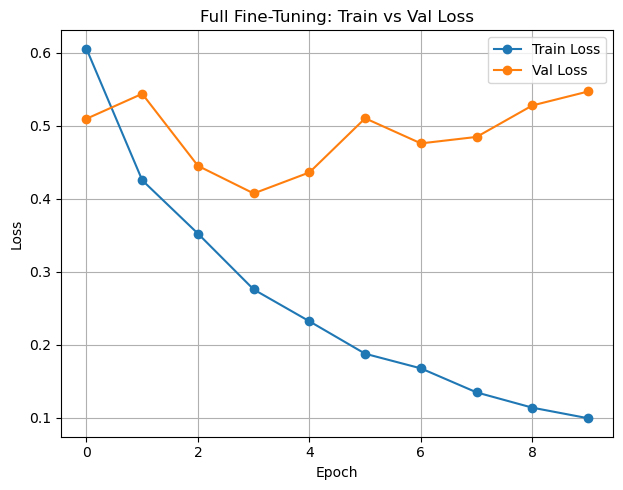

In [109]:
#LOSS GRAFİKLERİ(Full Fine-Tuning)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses_ft, label='Train Loss', marker='o')
plt.plot(val_losses_ft, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Full Fine-Tuning: Train vs Val Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

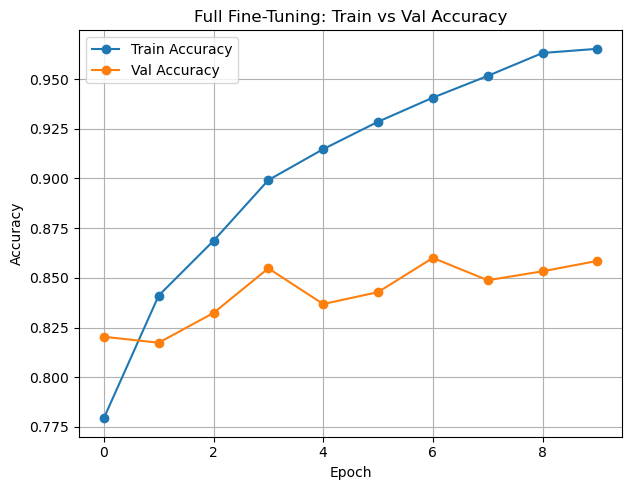

In [110]:
#ACCURACY GRAFİKLERİ(Full Fine-Tuning)
plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
plt.plot(train_accs_ft, label='Train Accuracy', marker='o')
plt.plot(val_accs_ft, label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Full Fine-Tuning: Train vs Val Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
#FINAL TEST(Fine-Tuned Model)
#EN İYİ FİNE-TUNED MODELİN YÜKLENMESİ VE DEĞERLENDİRMEYE HAZIRLANMASI
model.load_state_dict(torch.load("best_finetuned_model.pth"))
model.eval()
all_preds = []
all_labels = []

In [115]:
#TEST VERİ SETİ ÜZERİNDE TAHMİNLERİN HESAPLANMASI
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [116]:
#TEST VERİ SETİ ÜZERİNDE DOĞRULUK (ACCURACY) HESAPLAMA
test_correct = sum([p==t for p,t in zip(all_preds, all_labels)])
test_total = len(all_labels)
test_accuracy = test_correct / test_total

In [117]:
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8432


In [122]:
#CONFUSION MATRIX HESAPLAMA
cm = confusion_matrix(all_labels, all_preds)

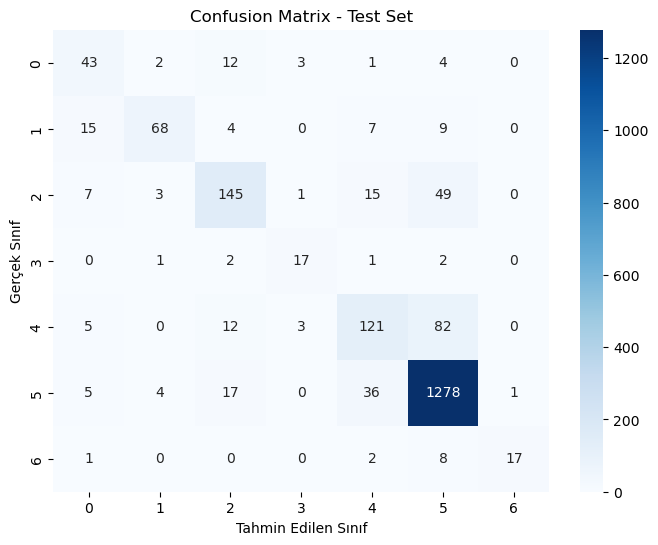

In [123]:
#CONFUSION MATRIX GRAFİĞİNİ ÇİZME VE GÖRSELLEŞTİRME
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [126]:
#CONFUSION MATRIX’İN YAZDIRILMASI
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[  43    2   12    3    1    4    0]
 [  15   68    4    0    7    9    0]
 [   7    3  145    1   15   49    0]
 [   0    1    2   17    1    2    0]
 [   5    0   12    3  121   82    0]
 [   5    4   17    0   36 1278    1]
 [   1    0    0    0    2    8   17]]


In [127]:
#CLASSIFICATION REPORT’UN YAZDIRILMASI
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.66      0.61        65
           1       0.87      0.66      0.75       103
           2       0.76      0.66      0.70       220
           3       0.71      0.74      0.72        23
           4       0.66      0.54      0.60       223
           5       0.89      0.95      0.92      1341
           6       0.94      0.61      0.74        28

    accuracy                           0.84      2003
   macro avg       0.77      0.69      0.72      2003
weighted avg       0.84      0.84      0.84      2003



In [131]:
#MULTI-CLASS ETİKETLERİNİ ONE-HOT ŞEKLİNDE HAZIRLAMA VE SKOR LİSTESİ OLUŞTURMA
y_true = label_binarize(all_labels, classes=[0,1,2,3,4,5,6])
y_score = []

In [132]:
#TEST SETİ ÜZERİNDE MODEL ÇIKTILARINI SOFTMAX İLE OLASILIK SKORLARINA ÇEVİRME
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        y_score.extend(probs.cpu().numpy())

y_score = np.array(y_score)

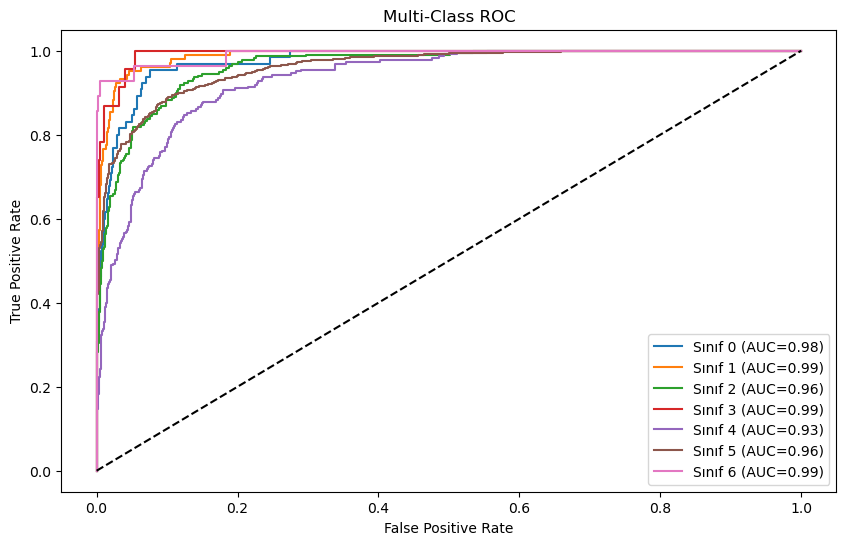

In [133]:
#MULTI-CLASS ROC EĞRİSİ ÇİZİMİ VE AUC HESAPLAMA
plt.figure(figsize=(10,6))
for i in range(7):
    fpr, tpr, _ = roc_curve(y_true[:,i], y_score[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Sınıf {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC')
plt.legend()
plt.show()

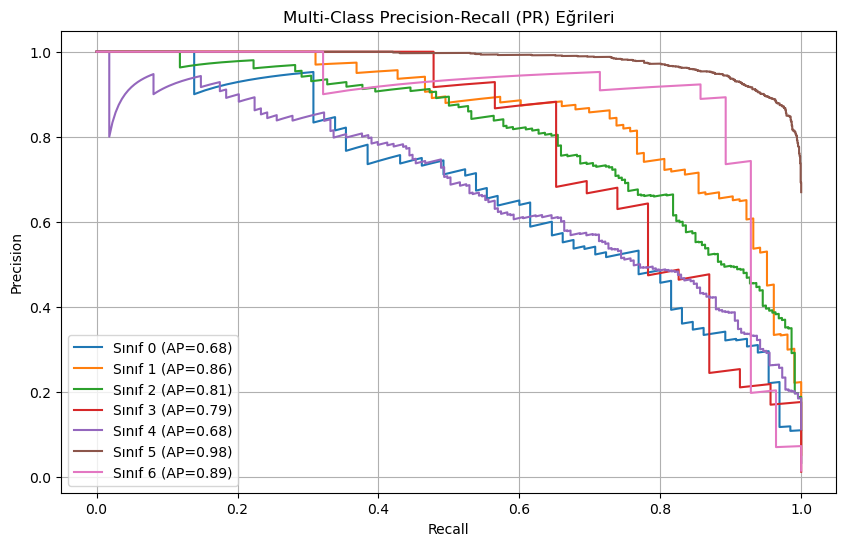

In [135]:
#MULTI-CLASS PRECISION-RECALL(PR) EĞRİLERİ
plt.figure(figsize=(10,6))
n_classes = y_true.shape[1]
#HER SINIF İÇİN PRECISION-RECALL(PR) HESABI VE ÇİZİMİ
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
    ap = average_precision_score(y_true[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f'Sınıf {i} (AP={ap:.2f})')

#MULTI-CLASS PRECISION-RECALL(PR) EĞRİLERİNİN GÖRSELLEŞTİRİLMESİ
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall (PR) Eğrileri')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [143]:
#KANSER SINIFLARININ TANIMLANMASI
cancer_classes = [0,1,2,4] 

In [144]:
#KANSER SINIFLARI İÇİN TRUE VE SCORE DEĞERLERİNİN HESAPLANMASI
y_true_cancer = np.isin(all_labels, cancer_classes).astype(int)
y_score_cancer = y_score[:, cancer_classes].sum(axis=1)  #seçili kanser sınıflarının olasılıklarının toplamı

In [145]:
#KANSER DIŞI SINIFLAR İÇİN TRUE VE SCORE DEĞERLERİNİN HESAPLANMASI
y_true_non_cancer = 1 - y_true_cancer
y_score_non_cancer = 1 - y_score_cancer


In [146]:
#KANSER SINIFI İÇİN ROC EĞRİSİ VE AUC HESABI
fpr_c, tpr_c, _ = roc_curve(y_true_cancer, y_score_cancer)
roc_auc_c = auc(fpr_c, tpr_c)

In [147]:
#NON-CANCER SINIFI İÇİN ROC EĞRİSİ VE AUC HESABI
fpr_nc, tpr_nc, _ = roc_curve(y_true_non_cancer, y_score_non_cancer)
roc_auc_nc = auc(fpr_nc, tpr_nc)


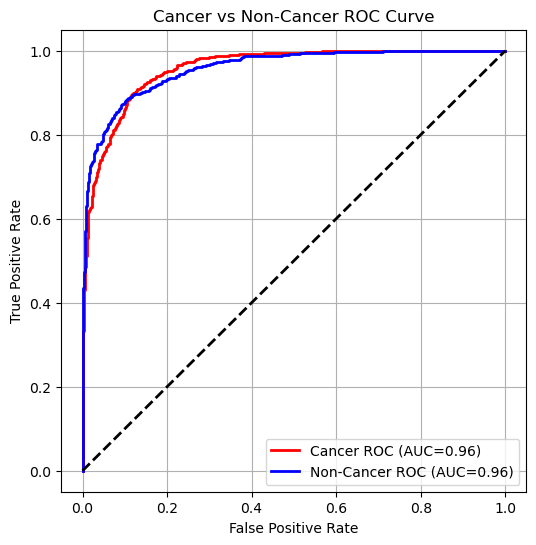

In [148]:
#CANCER VE NON-CANCER SINIFLARI İÇİN ROC EĞRİSİ GRAFİĞİ
plt.figure(figsize=(6,6))
plt.plot(fpr_c, tpr_c, color='red', lw=2, label=f'Cancer ROC (AUC={roc_auc_c:.2f})')
plt.plot(fpr_nc, tpr_nc, color='blue', lw=2, label=f'Non-Cancer ROC (AUC={roc_auc_nc:.2f})')
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Cancer vs Non-Cancer ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [153]:
#KANSER SINIFLARI İÇİN PRECISION-RECALL(PR) HESAPLAMA
precision_c, recall_c, _ = precision_recall_curve(y_true_cancer, y_score_cancer)
ap_c = average_precision_score(y_true_cancer, y_score_cancer)

In [154]:
#NON-CANCER SINIFLARI İÇİN PRECISION-RECALL(PR) HESAPLAMA
precision_nc, recall_nc, _ = precision_recall_curve(y_true_non_cancer, y_score_non_cancer)
ap_nc = average_precision_score(y_true_non_cancer, y_score_non_cancer)


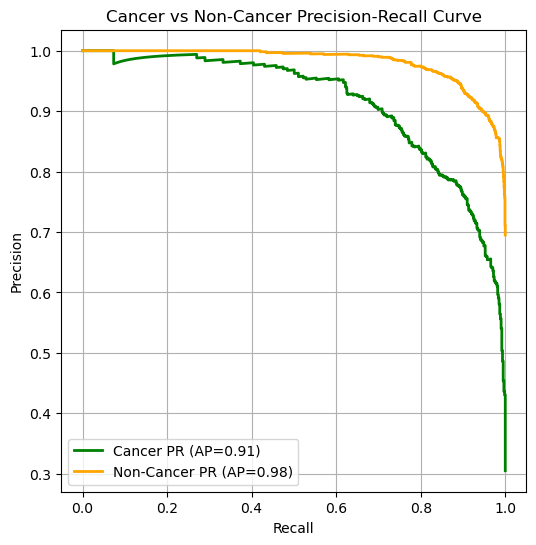

In [155]:
#CANCER VE NON-CANCER SINIFLARI İÇİN PRECISION-RECALL(PR) GRAFİĞİ
plt.figure(figsize=(6,6))
plt.plot(recall_c, precision_c, color='green', lw=2, label=f'Cancer PR (AP={ap_c:.2f})')
plt.plot(recall_nc, precision_nc, color='orange', lw=2, label=f'Non-Cancer PR (AP={ap_nc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Cancer vs Non-Cancer Precision-Recall Curve")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [163]:
#KLİNİK SINIFLARIN TANIMLANMASI(CANCER,PRE-CANCER,BENIGN)
cancer_classes = [0,1,2,4]   #akiec,bcc,bkl,mel
pre_cancer_classes = [3,6]   #df,vasc
benign_classes = [5]         #nv

In [164]:
#ETİKETİ KLİNİK SEVİYEYE DÖNÜŞTÜREN FONKSİYON
def clinical_level(pred_class):
    if pred_class in cancer_classes:
        return "Cancer"
    elif pred_class in pre_cancer_classes:
        return "Pre-Cancer"
    else:
        return "Benign"

In [165]:
#MODELİ DEĞERLENDİRME VE KLİNİK SEVİYE TAHMİNLERİ LİSTELERİNİN HAZIRLANMASI
model.eval()
clinical_preds = []
clinical_labels = []

In [166]:
#TEST VERİ SETİ ÜZERİNDE KLİNİK SEVİYE TAHMİNLERİNİN HESAPLANMASI
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        clinical_preds.extend([clinical_level(p) for p in preds.cpu().numpy()])
        clinical_labels.extend([clinical_level(l) for l in labels.cpu().numpy()])

In [167]:
#SON 6 ÖRNEK İÇİN GERÇEK VE TAHMİN EDİLEN KLİNİK SEVİYE KONTROLÜ
for i in range(-6,0):
    print(f"Gerçek: {clinical_labels[i]} | Tahmin: {clinical_preds[i]}")


Gerçek: Cancer | Tahmin: Cancer
Gerçek: Cancer | Tahmin: Cancer
Gerçek: Cancer | Tahmin: Pre-Cancer
Gerçek: Cancer | Tahmin: Cancer
Gerçek: Cancer | Tahmin: Cancer
Gerçek: Cancer | Tahmin: Cancer


In [168]:
#KLİNİK SEVİYE DOĞRULUK(ACCURACY) HESABI
correct = sum([p==t for p,t in zip(clinical_preds, clinical_labels)])
total = len(clinical_labels)
clinical_acc = correct / total

In [169]:
#3 SEVİYELİ KLİNİK DOĞRULUK(ACCURACY) ÇIKTI
print(f"\n3 Seviyeli Klinik Accuracy: {clinical_acc:.4f}")


3 Seviyeli Klinik Accuracy: 0.8847


In [174]:
#SON 6 TEST ÖRNEĞİNİ GÖRSELLEŞTİRME
last_6_indices = list(range(len(test_dataset)-6, len(test_dataset)))

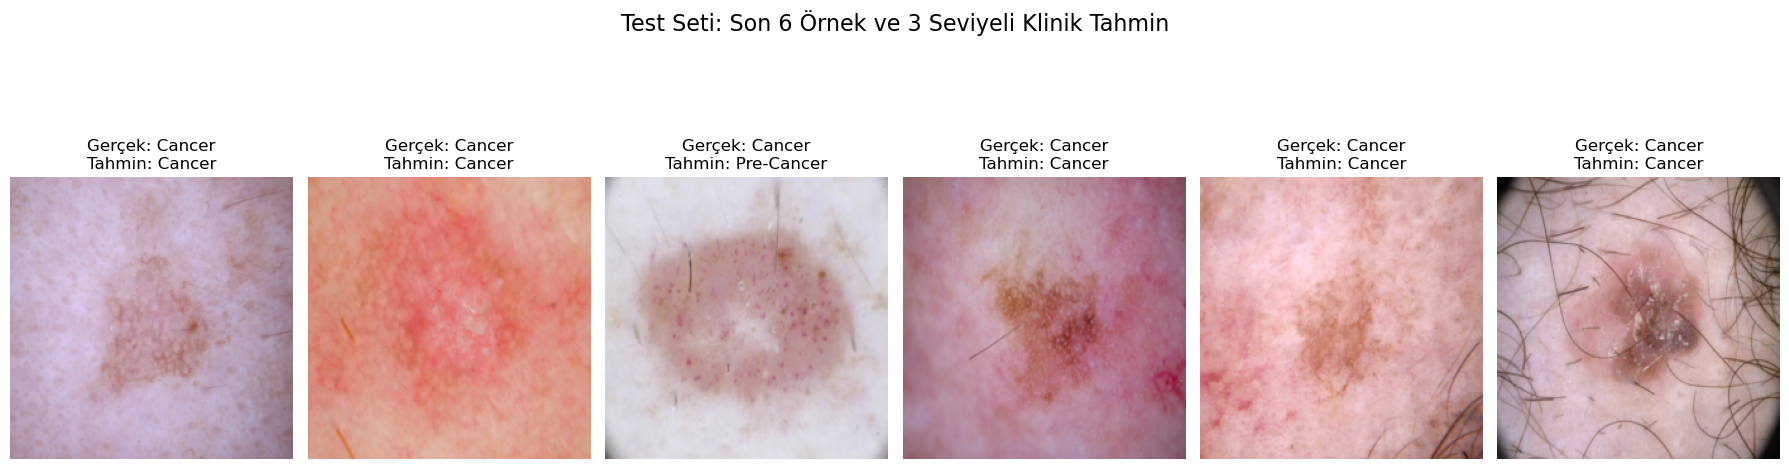

In [175]:
#SON 6 TEST ÖRNEĞİ İÇİN 3 SEVİYELİ KLİNİK TAHMİNİN GÖRSELLEŞTİRİLMESİ
plt.figure(figsize=(18,6))

#SON 6 TEST ÖRNEĞİNİN İNDİSLERİ ÜZERİNDE DÖNGÜ BAŞLATMA VE GÖRÜNTÜLERİN MODEL GİRİŞİNE HAZIRLANMASI
for i, idx in enumerate(last_6_indices):
    img, label = test_dataset[idx]
    img_input = img.unsqueeze(0).to(device)

    #MODELİN TEK GÖRÜNTÜ İÇİN TAHMİNİN ALINMASI VE KLİNİK SEVİYEYE DÖNÜŞTÜRÜLMESİ
    model.eval()
    with torch.no_grad():
        output = model(img_input)
        _, pred_class = torch.max(output, 1)
        pred_clinical = clinical_level(pred_class.item())
        true_clinical = clinical_level(label)

    #TEK GÖRÜNTÜNÜN GÖRSELLEŞTİRİLMESİ VE GERÇEK-TAHMİN ETİKETLERİNİN GÖSTERİLMESİ
    plt.subplot(1,6,i+1)
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = img_np * 0.5 + 0.5  # normalize ters çevir
    plt.imshow(img_np)
    plt.title(f"Gerçek: {true_clinical}\nTahmin: {pred_clinical}")
    plt.axis('off')

plt.suptitle("Test Seti: Son 6 Örnek ve 3 Seviyeli Klinik Tahmin", fontsize=16)
plt.tight_layout()
plt.show()


In [176]:
#SON 6 TEST ÖRNEĞİ:GRAD-CAM OVERLAY
#GRAD-CAM SINIFI
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._forward_handle = None
        self._backward_handle = None
        self.register_hooks()

    def register_hooks(self):
        #Önce varsa eski handle'ları kaldır
        if self._forward_handle:
            self._forward_handle.remove()
        if self._backward_handle:
            self._backward_handle.remove()

        #Forward hook
        def forward_hook(module, input, output):
            self.activations = output.detach()
        #Backward hook
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self._forward_handle = self.target_layer.register_forward_hook(forward_hook)
        self._backward_handle = self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, x, class_idx=None):
        x = x.unsqueeze(0).to(next(self.model.parameters()).device)
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        output[0,class_idx].backward()
        weights = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


In [177]:
#GRAD-CAM İÇİN MODELİN HANGİ KATMANININ KULLANILACAĞINI TANIMLAMA
grad_cam = GradCAM(model, model.layer4[1].conv1)

In [178]:
#TEST SETİNİN SON 6 ÖRNEĞİNİN İNDİSLERİNİ ALMA
last_6_indices = list(range(len(test_dataset)-6, len(test_dataset)))


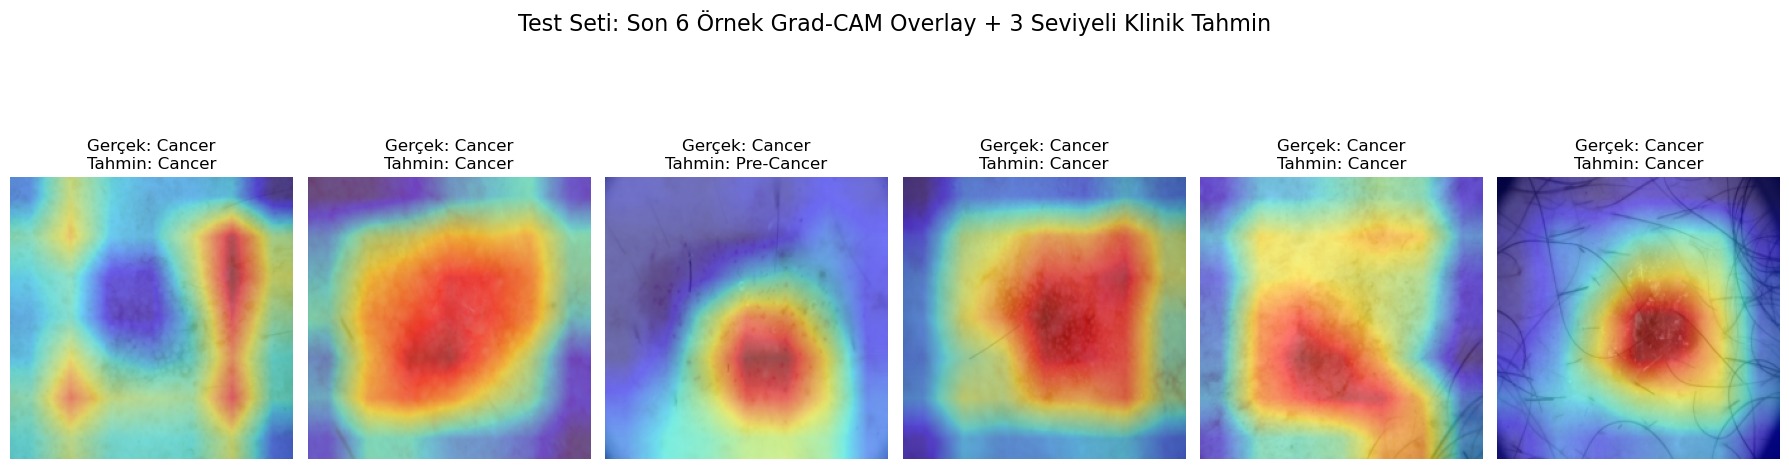

In [179]:
#TEST SETİNİN SON 6 ÖRNEĞİ İÇİN GRAD-CAM OVERLAY VE 3 SEVİYELİ KLİNİK TAHMİN GÖRSELLEŞTİRMESİ
plt.figure(figsize=(18,6))
for i, idx in enumerate(last_6_indices):
    img, label = test_dataset[idx]
    img_input = img.to(device)

    #Model tahmini
    model.eval()
    with torch.no_grad():
        output = model(img_input.unsqueeze(0))
        _, pred_class = torch.max(output,1)
        pred_clinical = clinical_level(pred_class.item())
        true_clinical = clinical_level(label)

    #Grad-CAM maskesi
    cam_mask = grad_cam.generate(img_input, class_idx=pred_class.item())

    #Görselleştirme
    plt.subplot(1,6,i+1)
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = img_np * 0.5 + 0.5  # normalize ters çevir
    plt.imshow(img_np)
    plt.imshow(cam_mask, cmap='jet', alpha=0.5)
    plt.title(f"Gerçek: {true_clinical}\nTahmin: {pred_clinical}")
    plt.axis('off')

plt.suptitle("Test Seti: Son 6 Örnek Grad-CAM Overlay + 3 Seviyeli Klinik Tahmin", fontsize=16)
plt.tight_layout()
plt.show() 

In [185]:
#TÜM TEST ETİKETLERİNİN VE TAHMİNLERİNİN NUMPY ARRAY’E DÖNÜŞTÜRÜLMESİ
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

In [186]:
#TOPLAM GERÇEK KANSER ÖRNEKLERİNİN SAYISININ HESAPLANMASI
total_cancer = np.sum(np.isin(y_true, cancer_classes))

In [187]:
#KANSER SINIFINDAKİ FALSE NEGATIVE(KAÇIRILAN KANSERLER) SAYISI
fn_cancer = np.sum(np.isin(y_true, cancer_classes) & ~np.isin(y_pred, cancer_classes))

In [188]:
#KANSER FALSE NEGATIVE ORANI(FN RATE)
fn_rate = fn_cancer / total_cancer if total_cancer > 0 else 0

In [189]:
#KANSER FALSE NEGATIVE RAPORU
print(f"Toplam Gerçekte Kanser: {total_cancer}")
print(f"Kaçırılan Kanser Sayısı: {fn_cancer}")
print(f"Cancer False Negative Rate: {fn_rate:.4f}")


Toplam Gerçekte Kanser: 611
Kaçırılan Kanser Sayısı: 151
Cancer False Negative Rate: 0.2471
